# Number detection from Indian Car Number Plates

In [ ]:
!unzip -qo data.zip

### Importing the Libraries

In [ ]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K

### Loading the required data from cascadeclassifier for detection

In [ ]:
plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')

### Let's declare a function for detect the plate

In [ ]:
def detect_plate(img, text=' '):
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7)
    #detect the number and finding the x,y,w,h dimensions
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate = roi[y:y+h, x:x+w, :]
        #drawing rectangles around the edges
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) 
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2),cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
    #returning the processed image
    return plate_img, plate

### Testing the above function

In [ ]:
def display(img_, title=''):
    #changinng colorspace from RGB to gray scale
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

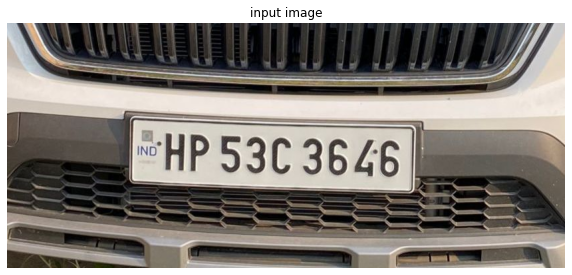

In [ ]:
#reading and displaying image and processed image
img = cv2.imread('/content/16.jpeg')
display(img, 'input image')

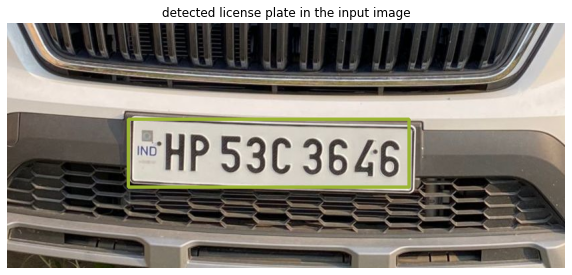

In [ ]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)
display(output_img, 'detected license plate in the input image')

### Displaying the detected number plate

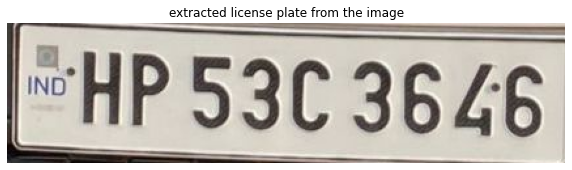

In [ ]:
display(plate, 'extracted license plate from the image')

### Match contours to license plate or character template

In [ ]:
def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    ii = cv2.imread('contour.jpg')
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours
            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)
            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

### Extracting the characters from image

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #applying morphological operations
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

### Let's see the segmented characters

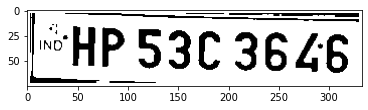

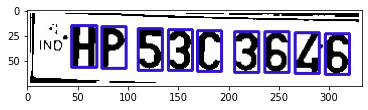

In [ ]:
char = segment_characters(plate)

In [ ]:
#providing the input training and validation data
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = "data"
train_generator = train_datagen.flow_from_directory(
        path+'/data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

### Building the model

In [ ]:
K.clear_session()
#creating sequential model
model = Sequential()
#creating convolutional kernal convolves with input or previus layer
model.add(Conv2D(8, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
#Downsamples the input
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
#Flattening the input
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
#defining the parameters
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         11624     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        8208      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        8224      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        16416     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                        

In [ ]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
            self.model.stop_training = True

### Training

In [ ]:
batch_size = 1
callbacks = [stop_training_callback()]
history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 50, verbose=1, callbacks=callbacks)

Epoch 1/50
864/864 [==============================] - 40s 44ms/step - loss: 3.3579 - custom_f1score: 0.0891 - val_loss: 2.3492 - val_custom_f1score: 0.3378
Epoch 2/50
864/864 [==============================] - 26s 30ms/step - loss: 1.8378 - custom_f1score: 0.4444 - val_loss: 1.0645 - val_custom_f1score: 0.7574
Epoch 3/50
864/864 [==============================] - 25s 29ms/step - loss: 1.0413 - custom_f1score: 0.6713 - val_loss: 0.8840 - val_custom_f1score: 0.7961
Epoch 4/50
864/864 [==============================] - 26s 31ms/step - loss: 0.7106 - custom_f1score: 0.7558 - val_loss: 0.4674 - val_custom_f1score: 0.8542
Epoch 5/50
864/864 [==============================] - 26s 30ms/step - loss: 0.6348 - custom_f1score: 0.7882 - val_loss: 0.3127 - val_custom_f1score: 0.9182
Epoch 6/50
864/864 [==============================] - 26s 30ms/step - loss: 0.4091 - custom_f1score: 0.8634 - val_loss: 0.2742 - val_custom_f1score: 0.9196
Epoch 7/50
864/864 [==============================] - 26s 30ms/s

### Predicting the output

In [ ]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict(img)[0]
        y_ = np.argmax(y_)
        #y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

### Printing the extracted text

In [ ]:
print(show_results())

HP53C36ZS


### Showing segmented results with predicted value

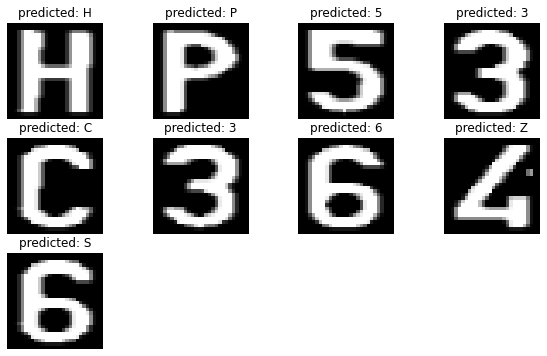

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

### Graph for loss and accuracy

dict_keys(['loss', 'custom_f1score', 'val_loss', 'val_custom_f1score'])


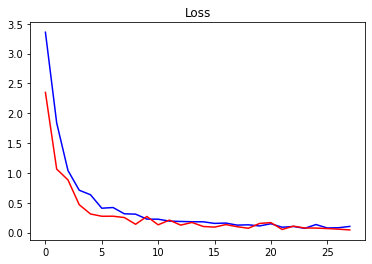

In [ ]:
print(history.history.keys()) # Displays keys from history, in my case loss,accuracy
plt.title('Loss')
plt.plot(history.history['loss'], color = 'b', label="train")
plt.plot(history.history['val_loss'], color = 'r', label="test")
plt.show()


dict_keys(['loss', 'custom_f1score', 'val_loss', 'val_custom_f1score'])


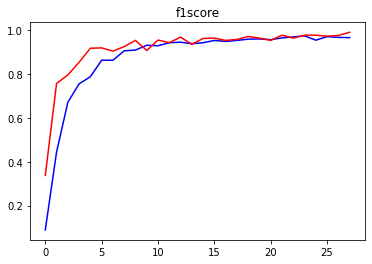

In [ ]:
print(history.history.keys()) # Displays keys from history, in my case loss,accuracy
plt.plot(history.history['custom_f1score'], color = 'b', label="train")
plt.plot(history.history['val_custom_f1score'], color = 'r', label="test")
plt.title('f1score')
plt.show()